# Empirical Probabilities

This notebook describes how to compute various “empirical probabilities”: computing marginal, joint, and conditional probabilities from available data.  You'll want to be familiar with the [notes on probability](../probability.md) before working through this notebook.

It's important to remember that using probabilities in this way is just **one way** of using probabilities; an empirical probability computed using the techniques in this notebook is not what a probability **is**; it's just a computation that probability can be used to describe.

This notebook uses some math macros in the course site theme which may not be available in Jupyter Notebook, so if you download the notebook file you may not be able to see all math correctly.

## Setup

Let's load our common packages:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data

We're going to do these demonstrations with the [Rent the Runway data](https://cseweb.ucsd.edu/~jmcauley/datasets.html#clothing_fit).

Let's load it:

In [2]:
rtr = pd.read_json('../data/renttherunway_final_data.json.gz', lines=True)
rtr.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


A little exploration - how many data points do we have here?

In [3]:
len(rtr)

192544

What is the distribution of 'fit' codes?

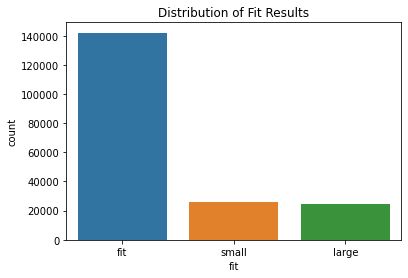

In [4]:
sns.countplot(x='fit', data=rtr)
plt.title('Distribution of Fit Results')
plt.show()

What is the distribution of garment categories?

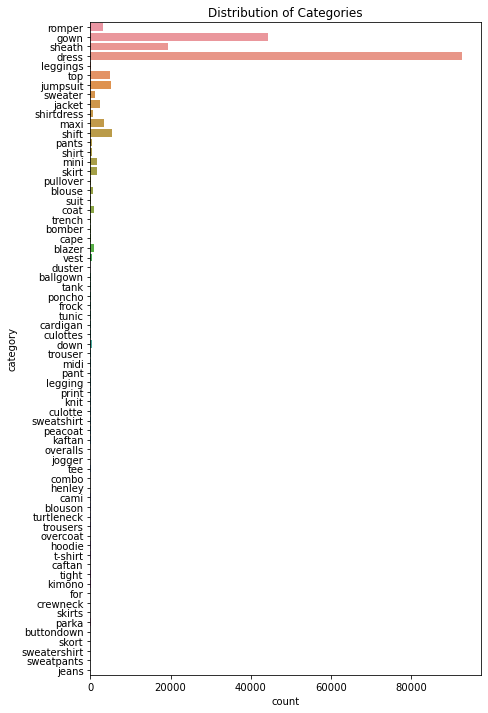

In [5]:
plt.figure(figsize=(7,12))
sns.countplot(y='category', data=rtr)
plt.title('Distribution of Categories')
plt.show()

It looks like we don't have a very clean category system here - 'dress' is a category, but so are additional categories of dresses and skirts.

## Basic / Marginal Probabilities

Let's consider garment fit (the `fit` column). This takes on one of three values (the *elementary events*):

- fit
- small
- large

Let's define each of these as an *event*, a singleton set:

- $A_{\mathrm{f}} = \{\mathrm{fit}\}$
- $A_{\mathrm{s}} = \{\mathrm{small}\}$
- $A_{\mathrm{l}} = \{\mathrm{large}\}$

The set “not fit” is $A_{\mathrm{f}}^c = \{\mathrm{small}, \mathrm{large}\}$.

Let's compute an empirical value $\P[A_{\mathrm{f}}] = \P[\mathrm{fit}]$ from the data.
This is a fraction:

$$\frac{\text{# of rentals that fit}}{\text{# of rentals}}$$

The basic principle is in two steps:

- create a logical series that has a non-null element for each element of the denominator, and is `True` for elements in the numerator
- compute the fraction of these elements that are `True` - {py:meth}`pandas.Series.mean` and {py:func}`numpy.mean` are both very good for this

Let's do that now:

In [6]:
fits = rtr['fit'] == 'fit'
fits.mean()

0.7377949975070633

73.8% of garments fit — $\P[A_{\mathrm{f}}] \approx 0.738$.

We can compute the complementary probability $\P[A_{\mathrm{f}}^c]$:

In [7]:
not_fits = rtr['fit'] != 'fit'
not_fits.mean()

0.26220500249293666

You can confirm that $\P[A_{\mathrm{f}}^c] = 1 - \P[A_{\mathrm{f}}]$.

We call $\P[A_{\mathrm{f}}]$ a *marginal probability*, even though we did not use marginalization to compute it.  The probability is what it is; its status as a marginal probability is based on the *definition* that it is the probability that a garment fits, without conditioning on any other criteria. Marginalization is a way to compute a marginal probability from conditional probabilities, but there are other ways as well, as we have seen.

There are a few ways to interpret about this probability:

- Probability is just a mathematical construct, and computing the fraction of garments that fit is compatible with that usage.
- If we randomly pick a garment rental from the data set, the probability that you pick a rental that fit is $\P[A_{\mathrm{f}}^c]$.
- If our sample is representative, and we assume a uniform prior (no prior knowledge about the probability a garment fitting), it is an estimate of the probability that a future rental will fit.

## Joint and Conditional Probabilities

Let's now look at **conditional probabilities**.  Suppose we want to compute $\P[A_{\mathrm{f}} | C_{\mathrm{g}}]$: the probability that a garment fits, given that it is a gown.  This probability can be expanded as:

$$\P[A_{\mathrm{f}} | C_{\mathrm{g}}] = \frac{\P[A_{\mathrm{f}}, C_{\mathrm{g}}]}{\P[C_{\mathrm{g}}]}
= \frac{\text{# of gowns that fit}}{\text{# of gowns}}$$

To do this, we need to compute the # of gowns, and the # of gowns that fit.  There are at least two different ways to do this; one is to compute joint and marginal probabilities separately.  We can use the Python `&` operator to compute the conjunction of two series, and the joint probability $\P[A_{\mathrm{f}}, C_{\mathrm{g}}]$:

In [8]:
is_gown = rtr['category'] == 'gown'
is_fitting_gown = is_gown & fits
is_fitting_gown.mean()

0.18269590327405683

This is the probability that a rental is both a gown, and it fits.  The complement contains all rentals that are for garments not labeled as gowns, and all gowns that do not fit.

We can then divide by the probability of a gown ($\P[C_{\mathrm{g}}]$, computed by `is_gown.mean()`):

In [9]:
is_fitting_gown.mean() / is_gown.mean()

0.7926139564227935

We can see that the probability of a garment fitting, given that it is a gown, is *somewhat higher* than the marginal probability of a garment fitting.  We don't know if this is statistically significant or not though.

The other way we can do this computation is to limit our data set to only gowns, and then compute the probability of a garment fitting *within that subset*.  The previous computation calculated the conditional probability by computing the joint and marginals, and using the relationship betwen joint and conditional probability to compute the conditional; this version of the calculation will compute the conditional probability $\P[A_{\mathrm{f}} | C_{\mathrm{g}}]$ *directly*.

Since we already have a boolean series that is `True` when the garment is a gown, we can use that to subset:

In [10]:
gowns = rtr[is_gown]
gowns

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"
8,fit,166228,36d,1729232,NaN,10.0,formal affair,I was nervous of it looking cheap when it arri...,full bust,Great for black tie event!,gown,"5' 6""",21,27.0,"June 27, 2016"
9,fit,154309,32b,1729232,114lbs,10.0,formal affair,The dress was very flattering and fit perfectl...,petite,This dress was everything! It was perfect for ...,gown,"5' 3""",1,33.0,"October 17, 2016"
14,fit,721308,34b,123793,118lbs,10.0,formal affair,"Fit great, super flattering",athletic,Stunning gown. Wore this for heart ball and re...,gown,"5' 5""",2,32.0,"May 29, 2014"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192506,fit,78599,NaN,672419,136lbs,10.0,party,"This was one of my backup dresses, and it work...",hourglass,The customer service impeccable!,gown,"5' 3""",12,35.0,"April 12, 2017"
192513,small,389288,34b,765872,145lbs,10.0,wedding,I ordered a 4L and it was perfect length but w...,athletic,Besides this dress just being stunning and sex...,gown,"5' 4""",17,34.0,"June 30, 2015"
192515,fit,378332,34d,125465,NaN,10.0,wedding,This was my backup dress to a black tie weddin...,NaN,So Flowy and Fun!,gown,"5' 7""",13,31.0,"June 10, 2016"
192524,fit,62024,32d,152662,130lbs,6.0,date,This was my backup dress I didn't end up weari...,hourglass,Pretty but kind of bland,gown,"5' 9""",4,35.0,"April 23, 2014"


Much smaller data set.  What's the probability of fitting ($\P[A_{\mathrm{f}} | C_{\mathrm{g}}]$)?

In [11]:
np.mean(gowns['fit'] == 'fit')

0.7926139564227935

Here I used {py:func}`numpy.mean` instead of the Pandas mean, just to demonstrate using it, and because its parentheses are slightly friendlier.

We can see these are the same probability.  Which method you want to use depends on the data you are working with and the other computations you're doing — use what is natural and makes sense in the context of your analysis.

## Conclusion

This notebook has demonstrated some basic computations for empirically estimating probabilities.  You can do quite a bit more, by:

- subsetting data
- using the `&` (and / conjunction / intersection) and `|` (or / disjunction / union) operators to combine boolean series

See the [Tricks with Boolean Series](BooleanSeries.ipynb) notebook for more about doing things with Boolean series.